In [1]:
from cognipy.ontology import Ontology
from cognipy.ontology import CQL
from cognipy.ontology import ABoxBatch
from cognipy.ontology import encode_string_for_graph_label
from cognipy.edit import CnlEditBox
from cognipy.edit import CnlQueryForConcept

import random
import textwrap
import numpy as np
import pandas as pd
import pickle

def graph_attribute_formatter(val):
    if isinstance(val,list) or isinstance(val,set):
        return " | ".join(list(map(lambda i:encode_string_for_graph_label(graph_attribute_formatter(i)),val)))
    elif isinstance(val,dict):
        return " | ".join(list(map(lambda i:i[0]+" : "+encode_string_for_graph_label(graph_attribute_formatter(i[1])),val.items())))
    else:
        return encode_string_for_graph_label(textwrap.fill(str(val),40))

from pint import UnitRegistry
ureg = UnitRegistry()
Q = ureg.Quantity

def Qstr(a):
    return "Q('"+str(a)+"')"
Q.__repr__=Qstr    


In [2]:
parts_editors={}

parts_editors['01']=CnlEditBox('border_cross_quarantine.encnl')
parts_editors['02']=CnlEditBox('face_cover.encnl')
parts_editors['03']=CnlEditBox('countries.encnl')
parts_editors['04']=CnlEditBox('lockdown.encnl')
parts_editors['05']=CnlEditBox('mass_coronavirus_testing.encnl')


<IPython.core.display.Javascript object>

In [3]:
def buildOntology(parts_editors,test_editor=None):
    return Ontology("cnl/string",
                    "\n\n".join(k.getvalue() for k in parts_editors.values())+('' if test_editor is None else test_editor.getvalue()), 
                    evaluator = lambda e:eval(e,globals(),locals()), 
                    graph_attribute_formatter = graph_attribute_formatter)

onto=buildOntology(parts_editors)

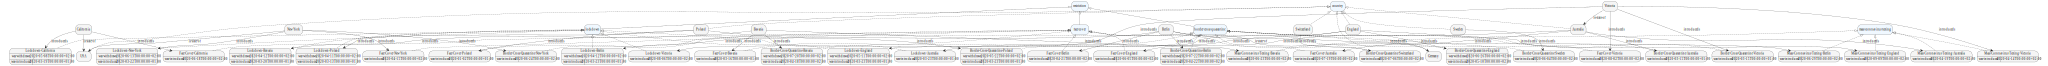

In [4]:
onto.draw_graph(layout='hierarchical')

In [5]:
onto.select_instances_of("a face-cover")

,Instance,was-introduced
0,Face-Cover-New-York,2020-04-15T00:00:00+02:00
1,Face-Cover-California,2020-06-18T00:00:00+02:00
2,Face-Cover-Victoria,2020-08-02T00:00:00+02:00
3,Face-Cover-Australia,2020-07-19T00:00:00+02:00
4,Face-Cover-England,2020-06-05T00:00:00+02:00
5,Face-Cover-Bavaria,2020-03-16T00:00:00+01:00
6,Face-Cover-Berlin,2020-04-21T00:00:00+02:00
7,Face-Cover-Poland,2020-01-02T00:00:00+01:00


In [6]:
df=onto.sparql_query(CQL("""select ?a1 ?a2 ?d{
                            ?a1 rdf:type <country>. 
                            ?a2 rdf:type <restriction>. 
                            ?a1 <introduceds> ?a2. 
                            ?a2 <was-introduced> ?d.
                        }"""))

In [7]:
df

,a1,a2,d
0,Switzerland,Border-Cross-Quarantine-Switzerland,2020-07-06T00:00:00+02:00
1,Australia,Lockdown-Australia,2020-03-23T00:00:00+01:00
2,Australia,Face-Cover-Australia,2020-07-19T00:00:00+02:00
3,Australia,Border-Cross-Quarantine-Australia,2020-03-15T00:00:00+01:00
4,England,Lockdown-England,2020-03-23T00:00:00+01:00
5,England,Face-Cover-England,2020-06-05T00:00:00+02:00
6,England,Border-Cross-Quarantine-England,2020-05-10T00:00:00+02:00
7,Sweden,Border-Cross-Quarantine-Sweden,2020-06-04T00:00:00+02:00
8,Poland,Lockdown-Poland,2020-03-13T00:00:00+01:00
9,Poland,Face-Cover-Poland,2020-01-02T00:00:00+01:00


In [11]:
df_tests = pd.read_csv('covid_tests.csv')
df_tests

,Entity,Code,Date,Total confirmed cases of COVID-19 per million people,Total confirmed cases of COVID-19 per million people Annotations,Total confirmed deaths due to COVID-19 per million people,Total confirmed deaths due to COVID-19 per million people Annotations,total_tests_per_thousand,total_tests_per_thousand Annotations
0,Afghanistan,AFG,2019-12-31,0.000,NaN,0.00,NaN,NaN,NaN
1,Afghanistan,AFG,2020-01-01,0.000,NaN,0.00,NaN,NaN,NaN
2,Afghanistan,AFG,2020-01-02,0.000,NaN,0.00,NaN,NaN,NaN
3,Afghanistan,AFG,2020-01-03,0.000,NaN,0.00,NaN,NaN,NaN
4,Afghanistan,AFG,2020-01-04,0.000,NaN,0.00,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
48820,Zimbabwe,ZWE,2020-10-01,527.352,NaN,15.34,NaN,8.109,tests performed
48821,Zimbabwe,ZWE,2020-10-02,528.160,NaN,15.34,NaN,NaN,NaN
48822,Zimbabwe,ZWE,2020-10-03,528.698,NaN,15.34,NaN,NaN,NaN
48823,Zimbabwe,ZWE,2020-10-04,530.515,NaN,15.34,NaN,NaN,NaN


In [8]:
df.set_index("d").resample("d").join(case.set_index("date"))

TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Index'